# Evaluation Metrics for Classification

## 1. Evaluation metrics: session overview

*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv('data/telco_customer_churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [8]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 
               'seniorcitizen', 
               'partner', 
               'dependents', 
               'phoneservice', 
               'multiplelines', 
               'internetservice', 
               'onlinesecurity', 
               'onlinebackup', 
               'deviceprotection', 
               'techsupport', 
               'streamingtv', 
               'streamingmovies', 
               'contract', 
               'paperlessbilling', 
               'paymentmethod']

In [9]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression().fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 2. Accuracy and dummy model

- Evaluate the model on different threshold
- Check the accuracy of dummy baselines

In [13]:
len(y_val)

1409

In [14]:
(y_val == churn_decision).sum()

1132

In [15]:
1132 / 1409 #Getting the accuracy

0.8034066713981547

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, churn_decision)

0.8034066713981547

accuracy_score need exact threshold so the accuracy that got is the best accuracy (for this case 0.5)

In [18]:
threshold = np.linspace(0, 1, 21)

scores = []

for t in threshold:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


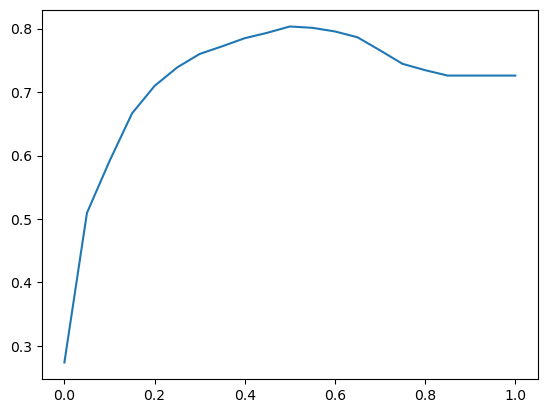

In [19]:
plt.plot(threshold, scores)

In [20]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

In [21]:
Counter(y_val)

Counter({0: 1023, 1: 386})

## 3. Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [25]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [26]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [27]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [28]:
tp, fp, fn, tn

(210, 101, 176, 922)

In [29]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [30]:
(confusion_matrix / confusion_matrix.sum()).round(3)

array([[0.654, 0.072],
       [0.125, 0.149]])

## 4. Precision & Recall

In [32]:
(tp + tn) / (tp + tn + fp + fn) #Calculate the accuracy

0.8034066713981547

In [33]:
precision = tp / (tp + fp) #Precision only focus on positive things
precision

0.6752411575562701

In [34]:
recall = tp / (tp + fn) #Recall only focus on the actual positive
recall

0.5440414507772021

## 5. ROC Curves

### TPR and FPR

- TPR : True Positive Rate (TP / (FN + TP))
- FPR : False Positive Rate (FP / (TN + FP))

In [38]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [39]:
fpr = fp / (tn + fp)
fpr

0.09872922776148582

In [40]:
scores = []

threshold = np.linspace(0, 1, 101)

for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [41]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [42]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,151,53,235,970
70,0.7,76,20,310,1003
80,0.8,14,2,372,1021
90,0.9,0,0,386,1023


In [43]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

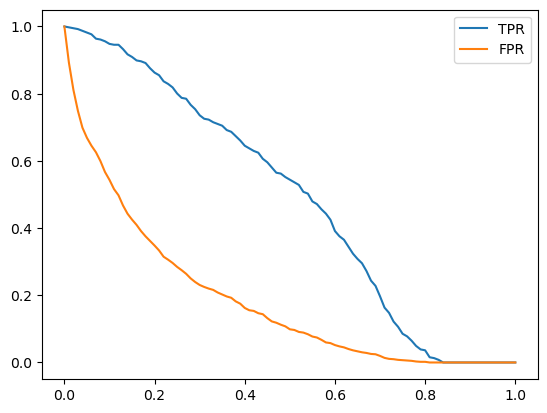

In [44]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

### Random Model

In [46]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [47]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [48]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    threshold = np.linspace(0, 1, 101)
    
    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [49]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

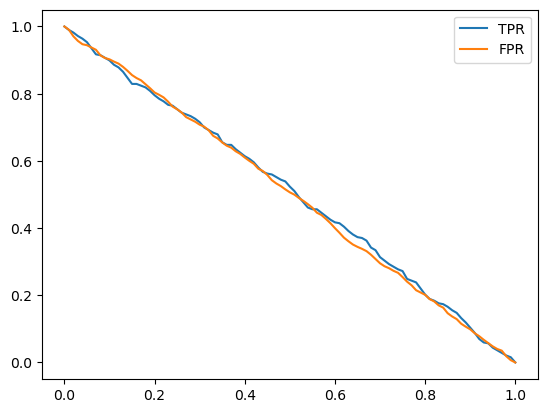

In [50]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

### Ideal model

In [52]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [53]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [54]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [55]:
# getting threshold from the actual data (the rate of no churn)
1 - y_val.mean()

0.7260468417317246

In [56]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [57]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

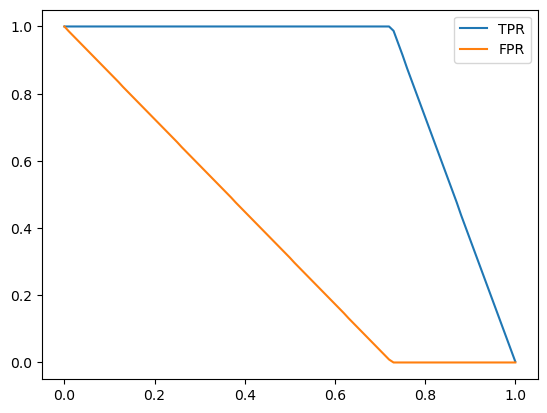

In [58]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

### Putting everything together

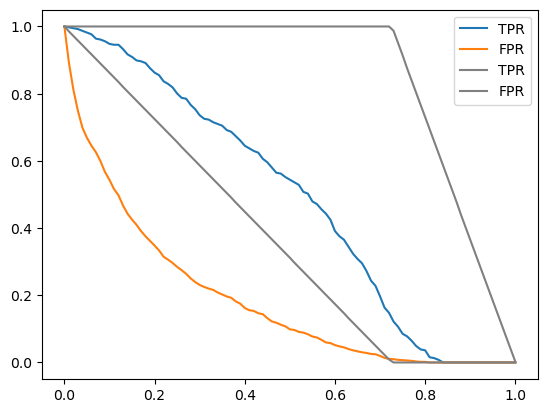

In [60]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

# plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
# plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='grey')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='grey')

plt.legend()

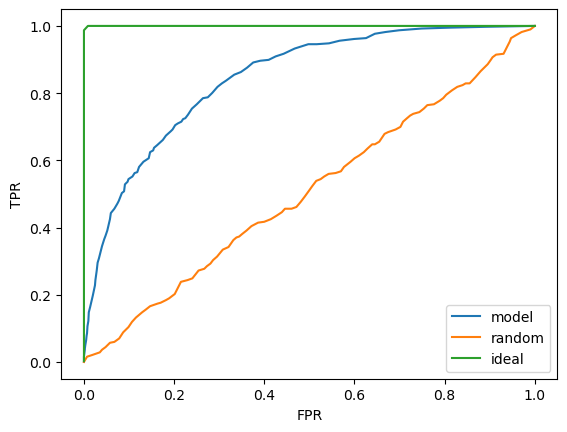

In [61]:
plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

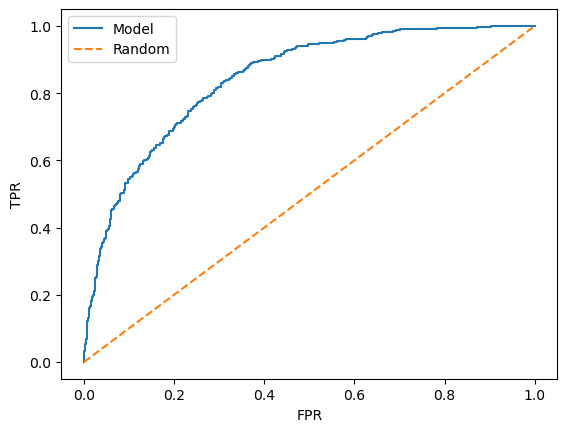

In [63]:
plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 6. ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

In [66]:
from sklearn.metrics import auc

In [67]:
auc(fpr, tpr)

0.8438251814484473

In [68]:
auc(df_scores.fpr, df_scores.tpr)

0.8438581030090306

In [69]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [70]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8438251814484473

In [71]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [72]:
import random

In [73]:
n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(neg)-1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8446

In [74]:
n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [75]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8352

## 7. Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [181]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y)

    return dv, model

In [79]:
dv, model = train(df_train, y_train, C=0.001)

In [80]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [81]:
y_pred = predict(df_val, dv, model)

In [82]:
from sklearn.model_selection import KFold

In [83]:
from tqdm import tqdm

In [171]:
n_splits = 5
result = []

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.churn.values
        y_val = df_val.churn.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    result.append([C, np.mean(scores), np.std(scores)])
    # print('%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [173]:
result

[[0.001, 0.8250885121892372, 0.009288148040525624],
 [0.01, 0.83994748246582, 0.008152980879796127],
 [0.1, 0.8417776224146001, 0.007205318114690126],
 [0.5, 0.8419505386287908, 0.00689173531771095],
 [1, 0.8420085279904435, 0.006863024045180357],
 [5, 0.8418992981338566, 0.006906999489692447],
 [10, 0.8418486641294969, 0.006891285490860034]]

In [183]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.858354458491772